# 🐟 Aquaculture Machine Learning Practice: will synthetic data do as well as the real data; how the two models perform in two different datasets; what if we combine the two datasets. if you run the code to generate the synthetic data multiple times; does it generate different and diverse sets? ........

**Objective:**  
Use machine learning to:
- Classify fish specie
- Predict fish weight

You will work with:
- A real dataset (Kaggle Fish Market)
- A synthetic aquaculture dataset (auto-generated)

Compare results between both datasets.


# Instructions

- Complete the notebook step by step.
- Write code in the cells marked "Your code here".
- You can run this notebook in Jupyter or Google Colab.
- Save your work and push it to the GitHub repository provided below, you also need to upload the notebook in canvas to prevent any point deduction
  > https://github.com/cyousra/Fish-Species.git

## 1️⃣ Setup

Run the cell below to import required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             mean_absolute_error, mean_squared_error, r2_score)
import joblib

RANDOM_STATE = 42
print(" Libraries loaded")

 Libraries loaded


## 2️⃣ Load Datasets

**A. Kaggle Fish Market Dataset**  
Download `Fish.csv` from Kaggle and place it in this folder.

**B. Synthetic Aquaculture Dataset**  
This dataset will be generated automatically.

In [2]:
# Load Kaggle dataset
import os
kaggle_path = 'Fish.csv'
if os.path.exists(kaggle_path):
    df_kaggle = pd.read_csv(kaggle_path)
    print(' Kaggle dataset loaded:', df_kaggle.shape)
    display(df_kaggle.head())
else:
    print(' File Fish.csv not found. Please download from Kaggle and save as Fish.csv.')

 File Fish.csv not found. Please download from Kaggle and save as Fish.csv.


In [3]:
# Generate synthetic dataset
def generate_synthetic(n=1000, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    length = np.random.normal(25, 8, n).clip(5, 60)
    height = (length * np.random.uniform(0.2, 0.4, n)).clip(1, 25)
    width = (length * np.random.uniform(0.1, 0.25, n)).clip(0.5, 15)
    temperature = np.random.normal(24, 2.5, n).clip(15, 30)
    pH = np.random.normal(7.5, 0.4, n).clip(6.5, 8.5)
    feed_rate = np.random.normal(100, 25, n).clip(20, 200)
    age_days = np.random.randint(30, 400, n)

    weight = 0.01 * length**2 + 0.5 * height + 0.3 * width + 0.02 * feed_rate + 0.05 * age_days
    weight *= np.random.normal(1.0, 0.07, n)

    species = []
    for L, H in zip(length, height):
        if L > 40 and H > 12:
            species.append('LargeBass')
        elif L > 30:
            species.append('Bass')
        elif L > 18:
            species.append('Trout')
        else:
            species.append('Small')

    disease_prob = ((temperature > 27) * 0.15 + (pH < 6.9) * 0.12 + (feed_rate < 50) * 0.10 + np.random.rand(n) * 0.05)
    disease = (disease_prob > 0.12).astype(int)

    df = pd.DataFrame({
        'length': length, 'height': height, 'width': width,
        'temperature': temperature, 'pH': pH, 'feed_rate': feed_rate, 'age_days': age_days,
        'weight': weight, 'species': species, 'disease': disease
    })
    return df

df_synth = generate_synthetic(1200)
print(" Synthetic dataset generated:", df_synth.shape)
display(df_synth.head())

 Synthetic dataset generated: (1200, 10)


,length,height,width,temperature,pH,feed_rate,age_days,weight,species,disease
0,28.973713,6.046307,6.422561,22.791096,7.492051,81.351447,315,29.011586,Trout,0
1,23.893886,7.804466,4.668703,22.469583,7.457094,83.461464,117,19.309840,Trout,0
2,30.181508,11.779259,4.775465,25.228019,7.988113,118.835487,264,32.276939,Bass,0
3,37.184239,11.910943,7.478477,23.104927,7.069328,84.636530,261,34.212338,Bass,0
4,23.126773,8.414394,3.214292,23.651507,7.194992,78.591287,36,13.738968,Trout,0


## 3️⃣ Explore and Prepare Data

Explore, clean, and prepare data for modeling:
- Check for missing values
- Visualize key features
- Encode labels if necessary


Using dataset: Synthetic Aquaculture
(1200, 10)
      length     height     width  temperature        pH   feed_rate  \
0  28.973713   6.046307  6.422561    22.791096  7.492051   81.351447   
1  23.893886   7.804466  4.668703    22.469583  7.457094   83.461464   
2  30.181508  11.779259  4.775465    25.228019  7.988113  118.835487   
3  37.184239  11.910943  7.478477    23.104927  7.069328   84.636530   
4  23.126773   8.414394  3.214292    23.651507  7.194992   78.591287   

   age_days     weight species  disease  
0       315  29.011586   Trout        0  
1       117  19.309840   Trout        0  
2       264  32.276939    Bass        0  
3       261  34.212338    Bass        0  
4        36  13.738968   Trout        0  

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   length       1200 non-null   float64
 1   height       12

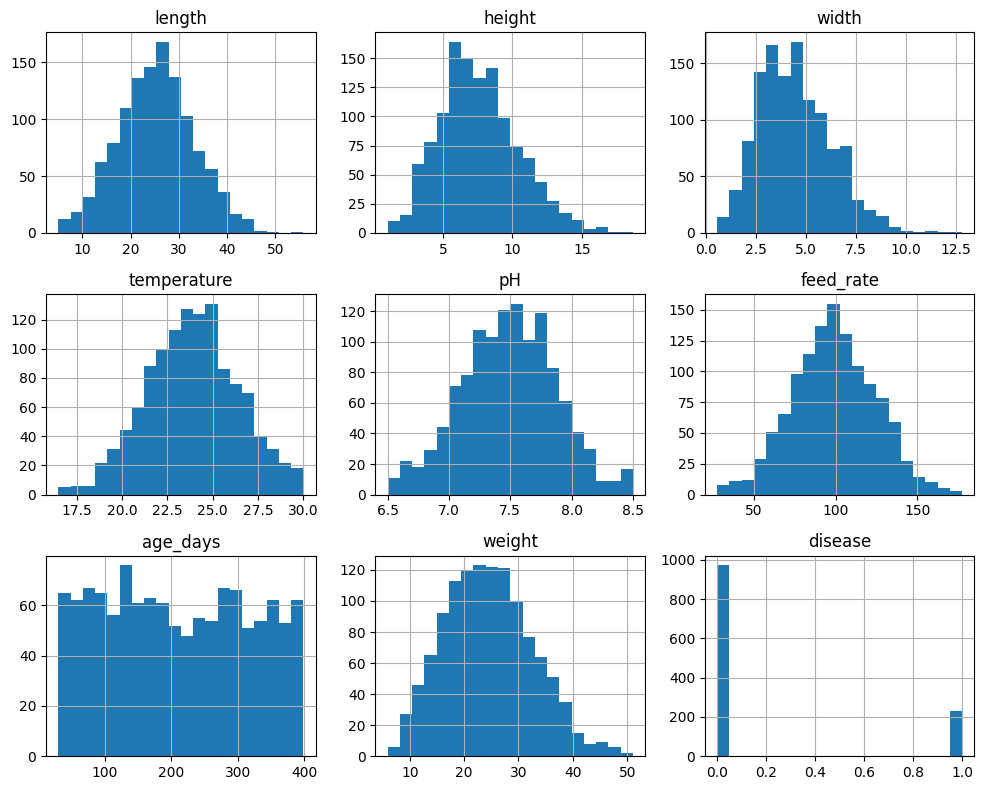

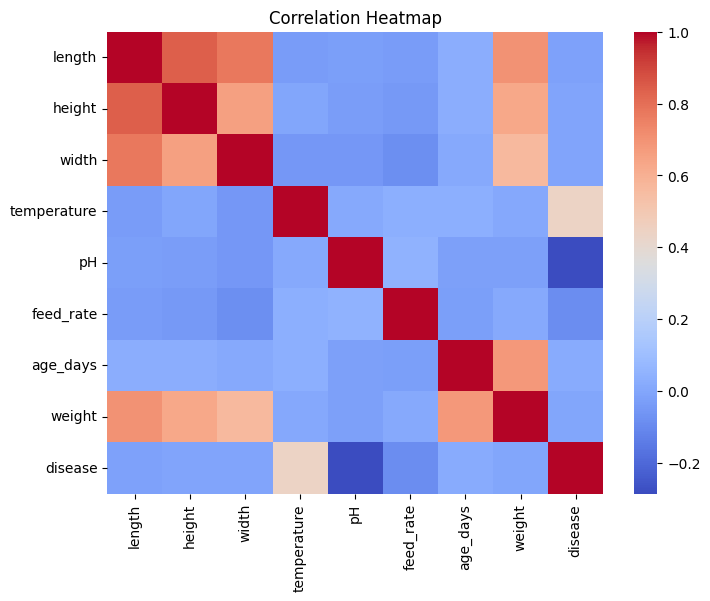

In [4]:
# ==== EDA & Preparation ====

# Select dataset (Kaggle if exists, else synthetic)
if 'df_kaggle' in globals():
    df = df_kaggle.copy()
    dataset_name = "Kaggle Fish Market"
else:
    df = df_synth.copy()
    dataset_name = "Synthetic Aquaculture"

print(f"Using dataset: {dataset_name}")
print(df.shape)
print(df.head())

# Info + Describe
print("\n--- INFO ---")
print(df.info())
print("\n--- DESCRIPTION ---")
print(df.describe(include='all'))

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

# Visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


## 4️⃣ Classification: Predict Fish Species

Use **two classifiers**:
- Logistic Regression  
- Random Forest Classifier  

Evaluate using:
- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix

Logistic Regression Accuracy: 0.923
Random Forest Accuracy:      0.997

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89        74
           1       1.00      0.14      0.25         7
           2       0.98      0.91      0.94        53
           3       0.93      0.98      0.95       166

    accuracy                           0.92       300
   macro avg       0.95      0.73      0.76       300
weighted avg       0.93      0.92      0.92       300


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        74
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00        53
           3       1.00      1.00      1.00       166

    accuracy                           1.00       300
   macro avg       0.97      1.00      0.98       300
weighted avg       1.00      1.00      1.00       300



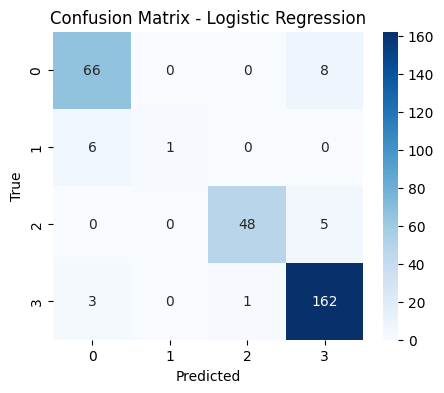

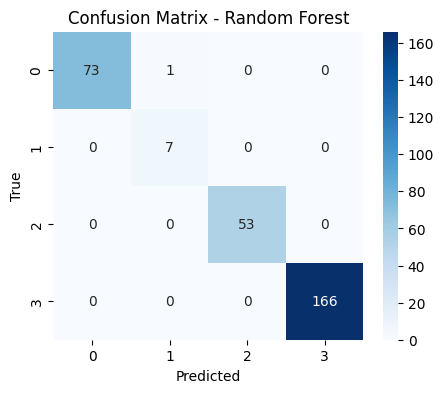

In [5]:
# ==== Classification Models ====

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Target: species (or disease if missing)
target = 'species' if 'species' in df.columns else 'disease'
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['weight'], errors='ignore')
y = df[target]

# Encode categorical target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
log_reg = LogisticRegression(max_iter=200, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)

# Fit models
log_reg.fit(X_train_scaled, y_train)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_rf = rf_clf.predict(X_test)

# Metrics
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"Random Forest Accuracy:      {accuracy_score(y_test, y_pred_rf):.3f}")

print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix Visualization
def plot_cm(y_true, y_pred, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(y_test, y_pred_lr, "Confusion Matrix - Logistic Regression")
plot_cm(y_test, y_pred_rf, "Confusion Matrix - Random Forest")


## 5️⃣ Regression: Predict Fish Weight

Use **two regressors**:
- Linear Regression  
- Random Forest Regressor  

Evaluate using:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² Score


Performance on test data:
Linear Regression: MAE=1.597, RMSE=2.160, R²=0.937
Random Forest: MAE=1.616, RMSE=2.251, R²=0.931


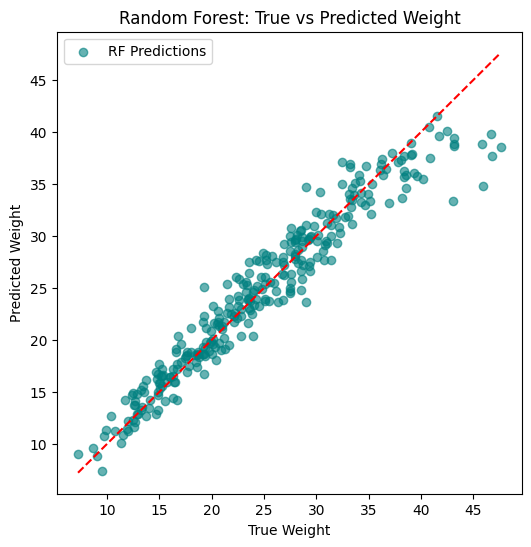

In [6]:
# ==== Regression Models ====

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Target variable
target = 'weight'
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=[target], errors='ignore')
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale for linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=300, random_state=42)

# Fit
lin_reg.fit(X_train_scaled, y_train)
rf_reg.fit(X_train, y_train)

# Predict
y_pred_lin = lin_reg.predict(X_test_scaled)
y_pred_rf = rf_reg.predict(X_test)

# Evaluation function (compatible version)
def eval_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # ✅ fixed for older sklearn
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")
    return mae, rmse, r2

print("Performance on test data:")
eval_model(y_test, y_pred_lin, "Linear Regression")
eval_model(y_test, y_pred_rf,  "Random Forest")

# Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='RF Predictions', color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Weight")
plt.ylabel("Predicted Weight")
plt.title("Random Forest: True vs Predicted Weight")
plt.legend()
plt.show()


## 6️⃣ Compare & Reflect

Compare your findings between the **Kaggle** and **synthetic** datasets.

**Reflection (write here):**
- Which dataset gave better accuracy and generalization?
- Which features were most important?
- How could ML impact aquaculture decision-making?


## 7️⃣ Submit Your Work to GitHub

Use the commands below in your terminal to upload your completed notebook.

```bash
git add Aquaculture_ML_Assignment.ipynb
git commit -m "Completed assignment by [Your Name]"
git push origin main
```

✅ Repository: https://github.com/cyousra/Fish-Species.git
